In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from dask.diagnostics import ProgressBar
from geocube.api.core import make_geocube

PATH = "D:\World Bank\CLIENT v2"
DATA_RAW = rf"{PATH}\Data\Data_raw"
DATA_PROC = rf"{PATH}\Data\Data_proc"
DATA_OUT = rf"{PATH}\Data\Data_out"

PARQUET_PATH = rf"{DATA_PROC}/shocks_by_adm"


c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
import xarray as xr

ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\IBTrACS_hurricanes_yearly.nc")
ds

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset> Size: 454GB
Dimensions:          (year: 51, y: 17173, x: 43200)
Coordinates:
  * y                (y) float64 137kB 83.62 83.61 83.6 ... -59.46 -59.47 -59.48
  * x                (x) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0
    spatial_ref      int32 4B ...
  * year             (year) int32 204B 1970 1971 1972 1973 ... 2018 2019 2020
Data variables:
    category_3_b10   (year, y, x) bool 38GB ...
    category_3_b100  (year, y, x) bool 38GB ...
    category_3_b25   (year, y, x) bool 38GB ...
    category_3_b50   (year, y, x) bool 38GB ...
    category_4_b10   (year, y, x) bool 38GB ...
    category_4_b100  (year, y, x) bool 38GB ...
    category_4_b25   (year, y, x) bool 38GB ...
    category_4_b50   (year, y, x) bool 38GB ...
    category_5_b10   (year, y, x) bool 38GB ...
    category_5_b100  (year, y, x) bool 38GB ...
    category_5_b25   (year, y, x) bool 38GB ...
    category_5_b50   (year, y, x) bool 38GB ...

In [12]:
import geopandas as gpd

path = "G:\Maestría\Tesis\Repo\data\data_out\gridded_predictions\effnet_v2S_lr0.0001_size128_y2013-2018-2022_stack1-4"
for year in [2013, 2018, 2022]:
    gdf = gpd.read_parquet(rf"{path}\effnet_v2S_lr0.0001_size128_y2013-2018-2022_stack1-4_141_predictions_{year}.parquet") 
    gdf = gdf[["id", "bounds_geom", "link", "real_value", "prediction", "prediction_error"]].rename(columns={"bounds_geom": "geometry", "prediction_error": "error"})
    gdf.set_geometry("geometry", inplace=True)
    gdf.to_file(rf"{path}\income_estimates_{year}.shp")

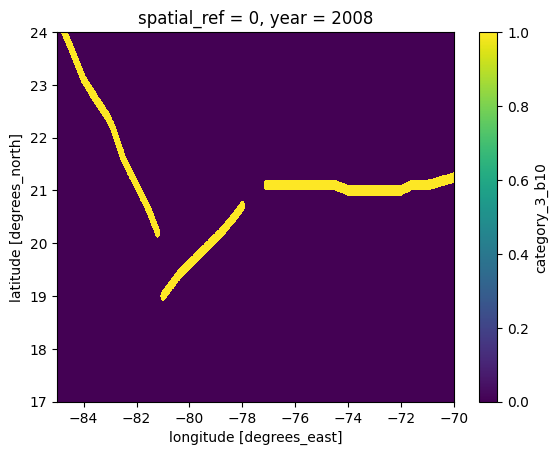

In [5]:
ds.sel(year=2008, x=slice(-85, -70), y=slice(24, 17))["category_3_b10"].plot()

In [15]:
gdf.head(20).explore().save("heat_map.html")


In [ ]:
import shapely

gdf = pd.read_parquet(r"D:\World Bank\CLIENT v2\Data\Data_proc\IPUMS_full.parquet")
# Parse geometry column from string to geometry
gdf["geometry"] = gdf["geometry"].apply(lambda x: shapely.wkt.loads(x))
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf = gdf.set_crs(epsg=4326)
IPUMS_countries = gdf.dissolve(by="CNTRY_CODE")

In [ ]:
IPUMS_countries.to_parquet(r"D:\World Bank\CLIENT v2\Data\Data_proc\IPUMS_international_bounds.parquet")

In [ ]:
gdf = gpd.read_feather(r"D:\World Bank\CLIENT v2\Data\Data_proc\WB_country_IDs.feather")
WB_countries = gdf.dissolve(by="ADM0_CODE")
WB_countries[["geometry"]].to_parquet(r"D:\World Bank\CLIENT v2\Data\Data_proc\WB_international_bounds.parquet")

In [ ]:
ds_mean = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_proc\heatwaves and coldwaves\frostdays_mean.nc")
ds_std = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_proc\heatwaves and coldwaves\frostdays_std.nc")


In [ ]:
ds_mean["timeseries-fd-monthly-mean"].sel(month=5).plot()

In [ ]:
ds_std

In [ ]:
ds["timeseries-fd-monthly-mean"].max()

In [ ]:
file = "timeseries-rx1day-monthly-mean_era_monthly_era5-0.5x0.5-timeseries_mean_1950-2020.nc"
ds = xr.open_dataset(rf"{DATA_RAW}\ERA5_CCKP\{file}", chunks={"time": 12})
ds = ds.sel(bnds=0).isel(time=slice(0, 24)) # both bands are the same
ds = ds.drop_vars(["lon_bnds", "lat_bnds", "bnds"])
ds = (ds["timeseries-rx1day-monthly-mean"] > 200)
ds_year = ds.groupby('time.year').max()
ds_year.sel(year=1951).plot()

In [ ]:
ds.drop("month")["timeseries-id-monthly-mean"].isel(time=600).plot()

In [ ]:
df = pd.read_parquet(r"D:\World Bank\CLIENT v2\Data\Data_out\")
ids = gpd.read_feather(rf"{DATA_PROC}\IPUMS_country_IDs.feather")
merged = ids.merge(df, on="ID")


# merged[merged["CNTRY_CODE"]==32]

In [ ]:
data = gpd.read_file(r"D:\World Bank\CLIENT v2\Data\Data_raw\IPUMS Fixed\geo2_us2000_2015.shp")
data#[data.duplicated(subset=["CNTRY_NAME", "GEOLEVEL2"])]

In [ ]:
arg = merged[merged["CNTRY_CODE"]==840]
arg
arg[arg.duplicated(subset=["CNTRY_CODE", "GEOLEVEL2", "year", "chunk"])]

In [ ]:
ids = gpd.read_feather(r"D:\World Bank\CLIENT v2\Data\Data_proc\IPUMS_country_IDs.feather")

In [ ]:
col = gpd.read_file(r"C:\Users\ofici\Downloads\geo2_co1973_2005\geo2_co1973_2005\geo2_co1973_2005.shp")
col.plot()

In [ ]:
# Filter 32.484701,28.060757,37.693608,34.383724
ids.cx[32.484701:37.693608, 28.060757:34.383724].explore()

In [ ]:
ids[ids["CNTRY_CODE"] == 704]

In [ ]:
ids[ids["GEOLEVEL1"] == 646002]


In [ ]:
ids[ids["GEOLEVEL2"] == 600001999]


In [ ]:
m = col[col["GEOLEVEL2"] == "170027004"].explore()
col_geo1[col_geo1["GEOLEVEL1"] == "170027"].explore(m=m, color="red")

In [ ]:
ids[ids["GEOLEVEL2"] == 170027004]

In [ ]:
ids[ids[]]

In [ ]:
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_proc\IPUMS_country_grid.nc")



In [ ]:
# ids.cx[32.484701:37.693608, 28.060757:34.383724].explore()
ds.sel(x=slice(32.484701, 37.693608), y=slice(34.383724, 28.060757)).ID.plot()

In [ ]:
# -74.047748,40.638723,-73.933391,40.719389

from geocube.vector import vectorize

grid_gdf = vectorize(ds.sel(x=slice(-74.047748, -73.933391), y=slice(40.719389, 40.638723)).ID.astype("float32"))


In [ ]:
ids[ids.GEOLEVEL2 == 840036721]

In [ ]:
m = ids[ids.GEOLEVEL2 == 840036721].explore()
grid_gdf.explore(m=m, column="ID")



In [ ]:
grid_gdf[grid_gdf.ID == 16380]

In [ ]:
hurr = pd.read_stata(r"D:\World Bank\CLIENT v2\Data\Data_out\IPUMS_hurricanes_wide.dta")


In [ ]:
hurr[hurr.geolevel2 == 32002001]

In [ ]:
ids[ids.GEOLEVEL2 == 170094001].explore()

In [ ]:
ids[ids.CNTRY_CODE == 170].explore()

In [ ]:
nombres = {170: }
errores = [170, 275, 376, 454, 508, 566, 604, 862]
diag = {code: (ids.CNTRY_CODE == code).sum() for code in errores}
diag

In [ ]:
import xarray as xr
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\ERA5_droughts_yearly.nc")
ds

In [ ]:
import matplotlib.pyplot as plt
import xarray as xr
from dask.diagnostics import ProgressBar
from dask.distributed import Client

client = Client()
client

In [ ]:
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\IBTrACS_hurricanes_yearly_fixed.nc", chunks={"x":  17173//2+1, "y": 43200//2+1, "year":100})
ds["year"] = range(1970, 2021)

ds.to_netcdf(r"D:\World Bank\CLIENT v2\Data\Data_out\IBTrACS_hurricanes_yearly.nc")
# ds.sel(x=slice(-80,-60), y=slice(30, 16), year=2008)["category_3_b10"].plot()
# ds.sel(x=slice(-55, -40), y=slice(-5, -25), year=2008)["SPEI-24"].plot(cmap="RdBu")

In [ ]:
ds

In [ ]:
ds

In [ ]:
ds["SPEI24_25sd"].sel(year=2008).plot()

In [ ]:
ds.sel(year=2008).to_netcdf(r"D:\World Bank\CLIENT v2\Data\Data_out\ERA5_droughts_2008.nc", encoding={col: {"zlib":True, "complevel": 9} for col in ds.data_vars})

In [ ]:
gpd.read_feather(rf"D:\World Bank\CLIENT v2\Data\Data_proc\WB_country_IDs.feather")

In [ ]:
import pandas as pd

df = pd.read_csv(rf"D:\World Bank\CLIENT v2\Data\Data_out\WB_drought_long.csv")
df

In [ ]:
df = df[(df["variable"]=="SPEI3") & (df["year"]==2008) & (df["threshold"] == "10sd") & (df["chunk"]==3)]
df[df["population_affected"]>1]

In [ ]:
test2 = pd.read_parquet(r"D:\World Bank\CLIENT v2\Data\Data_proc\shocks_by_adm\WB\out_drought_ungrouped.parquet")
test2

In [ ]:
test3 = test2[(test2["variable"]=="SPEI3") & (test2["year"]=="2008") & (test2["threshold"] == "10sd") & (test2["chunk"]=="3")]
test3

In [ ]:
def compress_dataframe(df):
    "" "Compress the dataframe to save memory" ""

    df["cells_affected"] = df["cells_affected"].fillna(0).astype(np.uint16)
    df["total_cells"] = df["total_cells"].fillna(0).astype(np.uint16)
    df["population_affected_n"] = (
        df["population_affected_n"].fillna(0).astype(np.uint64)
    )
    df["total_population"] = df["total_population"].fillna(0).astype(np.uint64)
    return df

compress_dataframe(test)

In [ ]:
import numpy as np
test = pd.read_parquet(r"D:\World Bank\CLIENT v2\Data\Data_proc\shocks_by_adm\WB\WB_drought_SPEI3_10sd_2008_3_zonal_stats.parquet")
test = test.reset_index().rename(columns={"index": "ID"})
test["year"] = 2008
test["variable"] = "SPEI3"
test["threshold"] = "10sd"
test = test.groupby(["ID", "year", "variable", "threshold"]).sum()
test["area_affected"] = test["cells_affected"] / test["total_cells"]
test["population_affected"] = test["population_affected_n"] / test["total_population"]
test = (
    test.drop(
        columns=[
            "cells_affected",
            "total_cells",
            "population_affected_n",
            "total_population",
        ]
    )
    .reset_index()
    .fillna(0)
    .replace([np.inf, -np.inf], 0)
)
test.area_affected.max()

In [ ]:
test

In [ ]:
df = pd.read_csv(r"D:\World Bank\CLIENT v2\Data\Data_proc\shocks_by_adm\WB\drought_wide.csv", nrows=1000)
df

In [ ]:
import xarray as xr
import utils
import geopandas as gpd
WB_data = gpd.read_feather(r"D:\World Bank\CLIENT v2\Data\Data_proc\WB_country_IDs.feather")
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_proc\IPUMS_country_grid.nc")
for i in range(16):
    datafilter, chunk_bounds = utils.get_filter_from_chunk_number(
        i, total_chunks=16, canvas=WB_data.total_bounds
    )
    print(datafilter)
ds

In [ ]:
chunk_adm_id = ds.sel({'x': slice(-179.99999999990004, -89.99999999990001, None), 'y': slice(-23.706354845399773, -59.48427929994972)}).ID
chunk_adm_id = chunk_adm_id.load()

(chunk_adm_id.fillna(99999) != 99999).sum()

In [ ]:
import utils
from tqdm import tqdm
shockname = "drought"
import dask.dataframe as dd
from dask.diagnostics import ProgressBar


In [ ]:
import geopandas as gpd

gdf = gpd.read_file(r"D:\Datasets\International Best Track Archive for Climate Stewardship (IBTrACS)\IBTrACS.ALL.list.v04r01.lines.shp")

In [ ]:
import xarray as xr

ds = xr.open_dataset(r"D:\Datasets\International Best Track Archive for Climate Stewardship (IBTrACS)\IBTrACS.ALL.v04r01.nc", chunks={"storm": 1})
ds

In [ ]:
from dask.diagnostics import ProgressBar
ds = ds.where(ds.storm.isin(storms))

with ProgressBar():
    ds = ds.compute()

In [ ]:
import numpy as np
storms = np.argwhere((ds.season == 1983).values).flatten()
storms

In [ ]:
from dask.distributed import Client
client = Client(n_workers=4, threads_per_worker=1, memory_limit='2GB')
client

In [ ]:
import numpy as np
import os

files = os.listdir(PARQUET_PATH)
files = [f for f in files if f.endswith(".parquet") and "drought" in f]

def func(partition, partition_info=None):
    try:
        return str(files[partition_info["number"]])
    except:
        print("No info")
        return ""

df = dd.read_parquet(os.path.join(PARQUET_PATH, "drought_*.parquet"))
df["filename"] = ""
df["filename"] = df["filename"].astype(str)
df["filename"] = df["filename"].map_partitions(func, enforce_metadata=True)
df["cells_affected"] = df["cells_affected"].fillna(0).astype(np.uint32)
df["total_cells"] = df["total_cells"].fillna(0).astype(np.uint32)
df["population_affected_n"] = df["population_affected_n"].fillna(0).astype(np.uint64)
df["total_population"] = df["total_population"].fillna(0).astype(np.uint64)

In [ ]:
import pandas as pd
df = pd.read_parquet(r"D:\World Bank\CLIENT v2\Data\Data_proc\shocks_by_adm\drought_SPI24_25sd_2008_14_zonal_stats.parquet")
df

In [ ]:
import importlib
importlib.reload(utils)

In [ ]:
import pandas as pd
import utils
import os
import numpy as np
import geopandas as gpd

path = r"D:\World Bank\CLIENT v2\Data\Data_proc\shocks_by_adm\WB"
f = f"WB_drought_SPI3_10sd_1987_2_zonal_stats.parquet"
shockname = "drought"
df = pd.read_parquet(os.path.join(path, f))
df = utils.compress_dataframe(df)
names = utils.parse_filename(f, shockname)
for col, value in names.items():
    df[col] = value
df = utils.process_chunk(df)


df = df.groupby(["ID", "name", "year"]).sum()
df["area_affected"] = df["cells_affected"] / df["total_cells"]
df["population_affected"] = df["population_affected_n"] / df["total_population"]
df = (
    df.drop(
        columns=[
            "cells_affected",
            "total_cells",
            "population_affected_n",
            "total_population",
        ]
    )
    .reset_index()
    .fillna(0)
    .replace([np.inf, -np.inf], 0)
)


pivot = df.pivot(
    index=["ID", "year"],
    columns="name",
    values=["population_affected", "area_affected"],
)


# Reindex the two-level columns pivot returns
newcols = []
for cols in pivot.columns:
    newcols += [utils.parse_columns(cols)]
pivot.columns = newcols
pivot = pivot.reset_index()

gdf = gpd.read_feather(r"D:\World Bank\CLIENT v2\Data\Data_proc\WB_country_IDs.feather")
out_df = gdf.merge(pivot, on="ID", validate="1:m", how="inner")

out_df[
    ["ADM0_CODE", "ADM1_CODE", "ADM2_CODE", "year", "ID"] + newcols
].to_stata(f"WB_{shockname}_by_admlast_sampled.dta")


In [ ]:
out_df[
    ["ADM0_CODE", "ADM1_CODE", "ADM2_CODE", "year", "ID"] + newcols
]

In [ ]:
import xarray as xr
xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\IBTrACS_hurricanes_yearly.nc")

In [ ]:
# Concatenate all the dataframes and create the shock variables
df = dd.concat(dfs)
df = df.groupby(["ID", "name", "year"]).sum()
df["area_affected"] = df["cells_affected"] / df["total_cells"]
df["population_affected"] = df["population_affected_n"] / df["total_population"]
df = (
    df.drop(
        columns=[
            "cells_affected",
            "total_cells",
            "population_affected_n",
            "total_population",
        ]
    )
    .reset_index()
    .fillna(0)
    .replace([np.inf, -np.inf], 0)
)



In [ ]:
import xarray as xr

#
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\IBTrACS_hurricanes_yearly.nc")

# Size in GB
ds["category_1_b10"].nbytes / 1e9 / 16

In [ ]:
floods = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\GFD_floods_yearly.nc")
floods.sel(year=2007).to_netcdf(r"D:\World Bank\CLIENT v2\Data\Data_out\GFD_floods_2007.nc", encoding={"band_data":{"zlib":True, "complevel":6}})

In [ ]:
import xarray as xr

xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\IBTrACS_hurricanes_yearly.nc")

In [ ]:
path = os.path.join(PARQUET_PATH, f"{shockname}_long.csv")
df.to_csv(path, single_file=True)
print(f"Se creó {path}")

df = pd.read_csv(path)
# Pivot data: every shock has to be a column
pivot = df.pivot(
    index=["ID", "year"],
    columns="name",
    values=["population_affected", "area_affected"],
)

# Reindex the two-level columns pivot returns
newcols = []
for cols in pivot.columns:
    newcols += [utils.parse_columns(cols)]
pivot.columns = newcols
pivot = pivot.reset_index()

path = os.path.join(PARQUET_PATH, f"{shockname}_wide.csv")
pivot.to_csv(path)
print(f"Se creó {path}")

pivot = pd.read_csv(path)

# Add the data to the gdf
out_df = gdf.merge(pivot, left_on="id", right_on="ID", validate="1:m", how="outer")


In [ ]:
import xarray as xr
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_1970_category_1_b100.nc")
# Select Florida
ds = ds.sel(y=slice(50, 10), x=slice(-100, -60))
ds["category_1_b100"].plot()

In [ ]:
import xarray as xr
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_1970_category_1_b100.nc", chunks={"x": 43200/10, "y": 17173//10})
# # Select Japan 120.937500,20.961441,149.589844,40.713957
# ds = ds.sel(y=slice(40.713957, 20.961441), x=slice(120.937500, 149.589844))
# ds["category_1_b100"].max()

In [ ]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    test = ds["category_1_b100"].coarsen(x=10, y=10, boundary="trim").max().plot()

In [ ]:
ds.coarsen(x=10, y=10, boundary="pad").max()["category_1_b100"].max()

In [ ]:
data = ["D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat4_1951_0.25.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1951_0.25.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1951_0.25.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1951_0.25.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat5_1951_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat4_1951_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1951_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1951_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1951_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat5_1951_1.0.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat4_1951_1.0.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1951_1.0.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1951_1.0.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1951_1.0.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat5_1951_0.5.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat4_1951_0.5.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1951_0.5.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1951_0.5.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1951_0.5.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat5_1951_0.25.nc"]

data2 = [
# "D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1952_0.25.nc"
# "D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1952_0.25.nc"
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat5_1952_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat4_1952_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1952_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1952_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1952_0.1.nc",
# "D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1952_0.25.nc"
]
import xarray as xr
xr.open_mfdataset([data, data2], combine='nested', concat_dim="year")

In [ ]:
import pandas as pd
import dask.dataframe as dd
df = dd.read_parquet(r"D:\World Bank\CLIENT v2\Data\Data_proc\shocks\drought_SPEI24_15sd_2020_15_zonal_stats.parquet")
df

In [ ]:
import os
import xarray as xr
from dask.diagnostics import ProgressBar

path = r"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes"
files = os.listdir(path)
dss = []
for year in range(1970, 2021):
    
    files_year = [os.path.join(path, f) for f in files if f"{year}" in f]
    dss += [xr.open_mfdataset(files_year)]
    
    if year==1975:
        break

ds = xr.concat(dss, dim="time")
with ProgressBar():
    ds.to_netcdf(r"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_1970_1975.nc")

In [ ]:
dss[10]

In [ ]:
import dask.dataframe as dd
df = pd.read_csv(r"D:\World Bank\CLIENT v2\Data\Data_proc\shocks\drought_long.csv")
pivot = df.pivot(
    index=["ID", "year"],
    columns="name",
    values=["population_affected", "area_affected"],
)
pivot

In [ ]:
xr.combine_by_coords(dss[1977])

In [ ]:
repl = {"year":"y", "lat":"y"}

df.columns

In [ ]:
import utils



In [ ]:
gdf = gpd.read_file(r"D:\Datasets\International Best Track Archive for Climate Stewardship (IBTrACS)\IBTrACS.ALL.list.v04r01.lines.shp")#, "BASIN", "SUBBASIN", "NAME", "ISO_TIME", "LAT", "LON", "WMO_WIND", "WMO_PRES", "WMO_AGENCY", "TRACK_TYPE"])
gdf["WMO_WIND"] = gdf["WMO_WIND"].ffill()
gdf[gdf.SID == "2021323S10103"].explore(column="WMO_WIND")